In [1]:
!pip install nltk


[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer


In [3]:
df = pd.read_csv('data.csv')


In [4]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df['Tweet'] = df['Tweet'].apply(lambda x: x.lower())#lowercase

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'(@[\w]+\s)+','username ',x))#username

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'http\S+|www\S+','http',x))#link

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'#(([\w]+\s[\w]+)+)',r'\1',x))#hashtags

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'(#[\w]+)+',' ',x))#hashtags

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('[^\w\?\!\s]','',x))#punctuation except ! and ? emoji 

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'\?+','? ',x))

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub(r'\!+','! ',x))

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('amp','and',x))

df['Tweet'] = df['Tweet'].apply(lambda x: re.sub('\s+',' ',x))#remove whitespaces

df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))#lemmatization


In [6]:
df['category'] = df['Label'].apply(lambda x: 1 if x =='Joyous' else 2 if x =='Sarcasm' else 0)

In [7]:
df.head()

,Label,Tweet,category
0,Schadenfreude,username did the police officer in question th...,0
1,Schadenfreude,username please report to the carwash your bit...,0
2,Sarcasm,username right wing christianity is a mean and...,2
3,Schadenfreude,username it part of history so no it wont what...,0
4,Sarcasm,username i guess the forecast wa wrong but at ...,2


In [8]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


In [9]:
X, y = df['Tweet'], df['Label']
metrics = []

skf = KFold(n_splits=5)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    vect = TfidfVectorizer(ngram_range=(1,3), max_features=1500)
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    svm = SVC()
    svm.fit(X_train_dtm, y_train)
    y_pred_class = svm.predict(X_test_dtm)

    metrics.append(accuracy_score(y_test, y_pred_class))

metrics = np.array(metrics)
print('Mean accuracy: ', np.mean(metrics, axis=0))
print('Std for accuracy: ', np.std(metrics, axis=0))
print(classification_report(y_test, y_pred_class))

Mean accuracy:  0.7256179152617832
Std for accuracy:  0.01951656873301528
               precision    recall  f1-score   support

       Joyous       0.63      0.94      0.75       280
      Sarcasm       0.75      0.39      0.51       216
Schadenfreude       0.87      0.77      0.82       305

     accuracy                           0.73       801
    macro avg       0.75      0.70      0.70       801
 weighted avg       0.75      0.73      0.71       801



In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

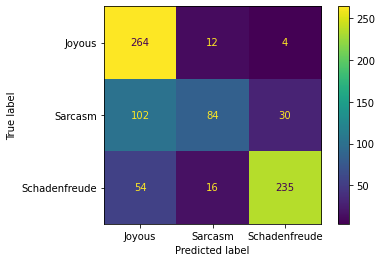

In [11]:
cm = confusion_matrix(y_test, y_pred_class, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()